In [1]:
from slab_dataset import get_linear_data, get_nonlinear_data, get_slab_data
from sklearn.model_selection import train_test_split

X_nonlinear, Y_nonlinear = get_nonlinear_data(30)
X_linear, Y_linear = get_linear_data(30)
X_train, X_test, Y_train, Y_test = train_test_split(*get_slab_data(), test_size=200, random_state=42)

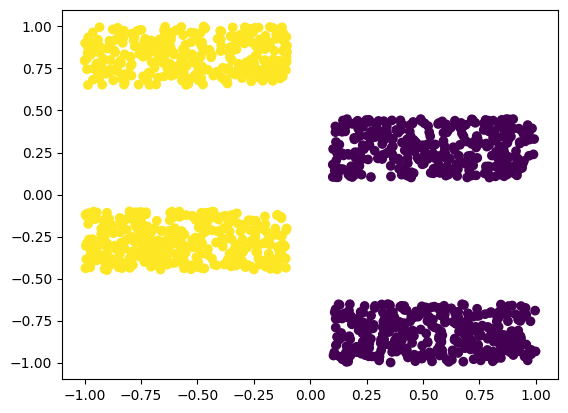

In [2]:
import matplotlib.pyplot as plt

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)

## Guess and check

In [3]:
from functools import partial
from tqdm.auto import trange
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3,6,7"

from flax import linen as nn
from optax.losses import sigmoid_binary_cross_entropy
import jax
import jax.numpy as jnp
import numpy as np


class MLP(nn.Module):
    hidden_sizes: tuple[int, ...]
    out_features: int
    param_dtype: jnp.dtype = jnp.float32

    @nn.compact
    def __call__(self, x):
        init_fn = partial(jax.random.uniform, minval=-1, maxval=1)

        for feat in self.hidden_sizes:
            x = nn.Dense(
                feat, bias_init=init_fn, kernel_init=init_fn, param_dtype=self.param_dtype,
            )(x)
            x = nn.relu(x)

        x = nn.Dense(
            self.out_features, bias_init=init_fn, kernel_init=init_fn, param_dtype=self.param_dtype,
        )(x)

        # Get rid of unnecessary trailing dimension
        return x.squeeze(1)


@partial(jax.vmap, in_axes=(0, None, None))
def guess_and_check(key, x_test, y_test):
    params = model.init(key, X_train[:1])

    logits = model.apply(params, x_test)
    test_acc = jnp.mean((logits > 0) == y_test, axis=0)

    return test_acc

@jax.pmap
def batch_gnc(keys):
    accs = guess_and_check(keys, X_jax, Y_jax)
    return jnp.mean(accs == 1.0, dtype=jnp.float32)

dtype = jnp.bfloat16
X_jax = jnp.array(X_nonlinear, dtype=dtype)
Y_jax = jnp.array(Y_nonlinear, dtype=dtype)
hit_probs = []
# We can use bfloat16 here because we aren't training at all
model = MLP(hidden_sizes=(40,), out_features=1, param_dtype=dtype)

for i in trange(10_000):
    keys = jax.random.split(jax.random.key(i), 1_000_000)
    hit_prob = batch_gnc(keys.reshape(4, -1)).mean()
    hit_probs.append(hit_prob)

/home/nora/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-09 21:33:33.933924: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


100%|██████████| 10000/10000 [01:55<00:00, 86.31it/s]


In [5]:
jnp.stack(hit_probs).mean()

Array(2.0099998e-08, dtype=float32)

In [4]:
from functools import partial

from flax import struct
from flax.training.train_state import TrainState
import optax

@struct.dataclass
class TrainConfig:
    batch_size: int = 200
    num_epochs: int = 3

    lr: float = 0.1


# Loss function
@partial(jax.value_and_grad, has_aux=True)
def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params, X)
    preds = logits > 0

    loss = sigmoid_binary_cross_entropy(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc


def train_step(state: TrainState, batch):
    metrics, grads = compute_loss(state.params, state.apply_fn, *batch)
    return state.apply_gradients(grads=grads), metrics


@partial(jax.vmap, in_axes=(0, None, None, None, None, None, None))
def train(key, x_train, y_train, x_test, y_test, apply_fn, cfg: TrainConfig):
    params = model.init(key, x_train)

    # LR schedule
    num_steps = cfg.num_epochs * len(x_train) // cfg.batch_size
    sched = optax.cosine_decay_schedule(cfg.lr, num_steps)

    # Define the optimizer and training state
    tx = optax.sgd(learning_rate=sched, momentum=0.9)
    state = TrainState.create(apply_fn=apply_fn, params=params, tx=tx)

    # RNG key for each epoch
    keys = jax.vmap(jax.random.key)(jnp.arange(cfg.num_epochs))
    shape = x_train.shape[1:]

    def epoch_step(state: TrainState, key) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        # Re-shuffle the data at the start of each epoch
        indices = jax.random.permutation(key, len(x_train))
        data_, labels_ = x_train[indices], y_train[indices]

        # Create the batches
        X_batched = jnp.reshape(data_, (-1, cfg.batch_size, *shape))
        Y_batched = jnp.reshape(labels_, (-1, cfg.batch_size))

        return jax.lax.scan(train_step, state, (X_batched, Y_batched))

    state, _ = jax.lax.scan(epoch_step, state, keys)

    logits = apply_fn(state.params, x_test)
    test_acc = jnp.mean((logits > 0) == y_test)
    #test_loss = sigmoid_binary_cross_entropy(logits, y_test).mean(0)
    return test_acc #state.params, metrics

/home/nora/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [04:16<00:00,  2.56s/it]


(array([  570751.,   746618.,  1340279.,  2130337.,  3094883.,  4333849.,
         6042496.,  8298547., 10760812., 13255668., 14421243., 18192018.,
        13389521.,  3362618.,    60360.]),
 array([0.53333336, 0.55111116, 0.5688889 , 0.5866667 , 0.6044445 ,
        0.62222224, 0.64000005, 0.65777785, 0.67555559, 0.69333339,
        0.71111119, 0.72888893, 0.74666673, 0.76444453, 0.78222227,
        0.80000007]),
 <BarContainer object of 15 artists>)

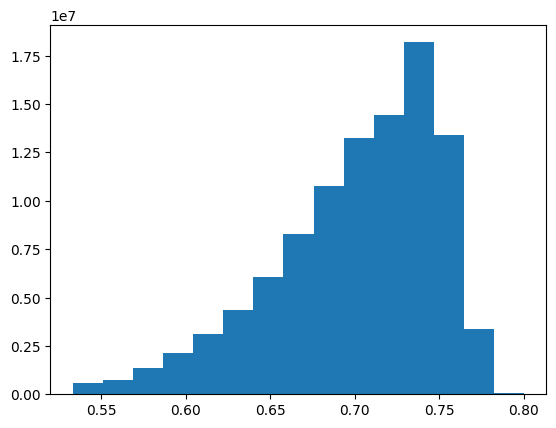

In [6]:
from tqdm.auto import trange

@jax.pmap
def train_fn(keys):
    return train(keys, jnp.array(X_train), jnp.array(Y_train), jnp.array(X_nonlinear), jnp.array(Y_nonlinear), model.apply, TrainConfig())

accs = []
for i in trange(100):
    keys = jax.random.split(jax.random.key(i), 1_000_000)
    accs.append(train_fn(keys.reshape(4, -1)))

accs = jnp.concatenate(accs).flatten()
import matplotlib.pyplot as plt
plt.hist(accs, bins=15)

In [7]:
accs.max()

Array(0.8000001, dtype=float32)

Text(0, 0.5, 'Linear Acc')

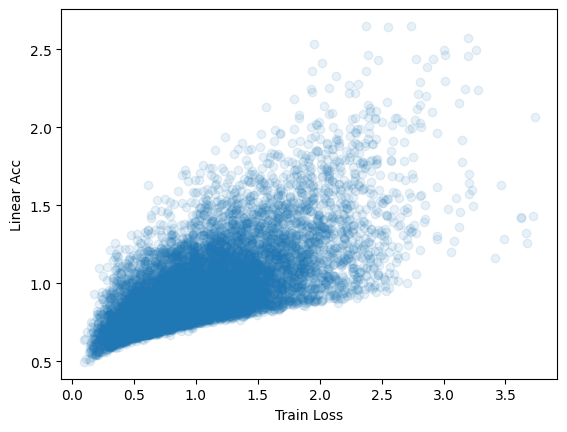

In [20]:
import matplotlib.pyplot as plt

plt.scatter(loss_train, acc_linear, alpha=0.1)
plt.xlabel("Train Loss")
plt.ylabel("Linear Acc")